In [698]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import json

def generate_ARHT(t_0, T, num_harmonics = 0, coeffs = None, periods = None, max_period = 105, min_period = 5,
                  trend = False, power = 0, const = 0, var = 1, alpha = 0.01):
    signal = np.zeros(T - t_0 + 1)
    t = np.arange(t_0,T+1,dtype = float)
    if num_harmonics: #todo: Check consistant number of harmonics length of coeffs and periods
        if coeffs is None:
            coeffs = 2 * np.random.random(num_harmonics) + 0.3
        if periods is None:
            periods = ((max_period-min_period)* np.random.random(num_harmonics) + min_period)
        print(periods)
        for i in range(num_harmonics): 
            signal += coeffs[i] * np.sin((t/(T - t_0 + 1))*periods[i]*2.0*np.pi)
    if trend: #add more trend types
        signal += (alpha * t**power).astype(float)
    if const: 
        signal += const
    noise = np.random.normal(0.0, np.sqrt(var), T - t_0 + 1)
    noisy_ts = signal + noise
    return noisy_ts, signal

def get_singular_values(ts, num_windows, L = None,k = 3):
    
    T = ts.shape[0]//num_windows
    if L is None:
        L = int(np.sqrt(T))
    M = T//L
    T = L*M
    print(L,M,T)
    S = np.zeros([num_windows, L])
    for i in range(num_windows):
        A = ts[T*(i):T*(i+1)].reshape([L, M], order = 'F')
        U,s, _ = np.linalg.svd(A, full_matrices= False)
        S[i,:] = s
        if i >0:
            perp_basis = U_old[:, k:]
            D_t = (np.linalg.norm(perp_basis.T @ A[:,1:], 2,0).max())**2
            print(f'distance: {D_t}')
        else:
            U_ = U
        U_old = U
            
    return S, U_, A

In [699]:
T = 100000
power = 3; alpha = 1e-10
ts_, tm_ = generate_ARHT(0, T, num_harmonics = 4, trend = 0, power = power, var = 0, alpha = alpha)
tm_[T//2:] = 0.2*tm_[T//2:]


[55.50489482 30.14006227 94.6581293  78.51758177]


In [700]:

S,U,A = get_singular_values(tm_, 2)


223 224 49952
distance: 0.00019966695338992325


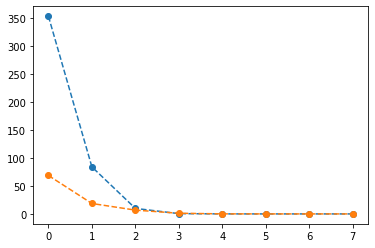

In [332]:
plt.figure()
k = 8
plt.plot(S[:,:k].T, 'o--')


2.85356602387267e-26

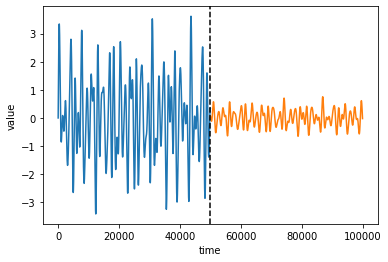

In [701]:
plt.plot(tm_[:T//2])
plt.plot(np.arange(T//2, T+1),tm_[T//2:])
plt.xlabel('time')
plt.ylabel('value')
plt.axvline(T//2, color = 'k', linestyle = 'dashed')
perp_basis = U[:, k:]
D_t = (np.linalg.norm(perp_basis.T @ A[:,1:], 2,0).max())**2
D_t
# plt.savefig('example.png')

### tests

In [719]:
T = 500000
power = 1; alpha = 5e-5; num_harmonics = 10; periods = None
ts_, tm_ = generate_ARHT(0, T, num_harmonics = num_harmonics, trend = 0, power = power, var = 0,  alpha = alpha, periods = periods)
N = 10
S,_,_ = get_singular_values(ts_, N)




[66.13331103 61.8420091  78.02427961 75.6399231   7.04395339 49.80816359
 51.15809186 15.36694333 55.0045005  29.59941421]
223 224 49952
distance: 4.230711070765577e-07
distance: 3.964058097645941e-07
distance: 2.807592357661646e-07
distance: 6.66376168827919e-07
distance: 5.403584359023968e-07
distance: 3.4581702017897086e-07
distance: 5.017216191408789e-07
distance: 6.732178962648874e-07
distance: 4.3521892032449446e-07


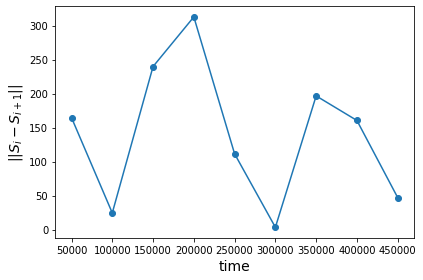

In [720]:
plt.figure()
k = 14
indices = np.linspace(0, T-1, N+1)
diff = []
for i in range(N-1):
    diff.append(np.linalg.norm(S[i,:]- S[i+1,:]))#/np.linalg.norm(S[i,:]) )
    
plt.plot(indices[1:-1], diff,'-o')
plt.xlabel('time',fontsize = 14)
plt.ylabel('${||S_i-S_{i+1}||}$', fontsize = 14)
plt.tight_layout()
plt.savefig(f'difference_{num_harmonics}_t.png')

In [721]:
indices

array([     0. ,  49999.9,  99999.8, 149999.7, 199999.6, 249999.5,
       299999.4, 349999.3, 399999.2, 449999.1, 499999. ])

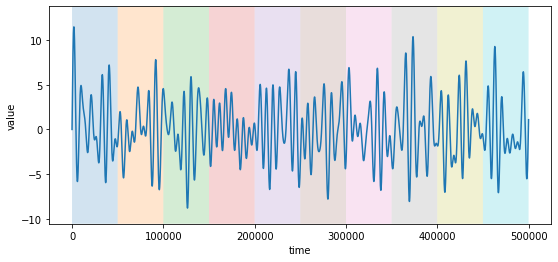

In [722]:
plt.figure(figsize = (9,4))
plt.plot(ts_[:])
plt.xlabel('time')
plt.ylabel('value')
lim = max(ts_)*1.2
min_ = min(ts_)*1.2
plt.ylim([min_,lim])
start =0
for i in indices[1:]:
    plt.fill_between(np.arange(start,i),min_,lim, alpha = 0.2)
    start = i
plt.savefig(f'windows_{num_harmonics}_t.png')

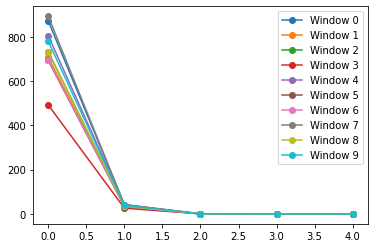

In [723]:
plt.figure()
plt.plot(S[:,:5].T,'-o')
plt.legend([f'Window {i}' for i in range(N)])
plt.savefig('singular_values_t.png')

In [539]:
S.shape

(4, 353)